# CSCI 5922 (Spring 2020) Final Project
name: Timothy Mason
***
Music Genre classification using a CRNN as described in the paper blah, blah, blah...

todo: fill in citations and flesh out overview

last.fm dataset citation:

> @INPROCEEDINGS{Bertin-Mahieux2011,
  author = {Thierry Bertin-Mahieux and Daniel P.W. Ellis and Brian Whitman and Paul Lamere},
  title = {The Million Song Dataset},
  booktitle = {{Proceedings of the 12th International Conference on Music Information
	Retrieval ({ISMIR} 2011)}},
  year = {2011},
  owner = {thierry},
  timestamp = {2010.03.07}
}

> Additionally, you can mention / link to this web resource:
> 
> Last.fm dataset, the official song tags and song similarity collection for the Million Song
> Dataset, available at: http://millionsongdataset.com/lastfm

In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm      # for easy and attractive progress bars

import hdf5_getters        # https://github.com/tbertinmahieux/MSongsDB/tree/master/PythonSrc
# hdf5_getters.py is Copyright 2010, Thierry Bertin-Mahieux
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

## Import data functions

In [2]:
# see http://docs.echonest.com.s3-website-us-east-1.amazonaws.com/_static/AnalyzeDocumentation.pdf for
# detailed discussion of the category data items
def hdf_tree_to_dataframe(msd_path='./MillionSongSubset/data',
                          categories=("track_id",
                                      "artist_name",          # Name of the artist
                                      "release",              # Album name
                                      "title",                # Title of the piece
                                      "year",                 # year released (unreliable - often 0)
#                                       "analysis_sample_rate", # sample rate (Hz) for the analysis
#                                       "duration",             # length of the piece (seconds)
#                                       "tempo",                # tempo of the piece (avg beats per minute)
#                                       "beats_start",          # list of time markers (seconds) for beats
#                                       "bars_start",           # list of time markers (seconds) for bars
#                                       "tatums_start",         # "list of tatum markers, in seconds. Tatums 
#                                                               # represent the lowest regular pulse train that
#                                                               # a listener intuitively infers from the timing
#                                                               # of perceived musical events (segments)."
#                                       "segments_start",       # list of time markers (seconds) for segments
                                      "segments_pitches",     # list of 12-ary vectors, each contains relative
                                                              # strength of the notes (pitches) contained in 
                                                              # a segment.  0 = strength(0..1) of the C note, 
                                                              # 1 = strength of C-sharp, 
                                                              # ... 
                                                              # 11 = B
                                      "segments_timbre",      # list of 12-ary vectors, "timbre is the quality
                                                              # of a musical note or sound that distinguishes 
                                                              # different types of musical instruments, or 
                                                              # voices. It is a complex notion also referred 
                                                              # to as sound color, texture, or tone quality, 
                                                              # and is derived from the shape of a segment’s 
                                                              # spectro-temporal surface, independently of 
                                                              # pitch and loudness. "
                                     ), 
                          first = 0, last = None):
    """
    Walk the directory structure of the provided path, and read data from the
    *.h5 files in all subdirectories.

    Parameters
    ----------
    categories: set of keyword strings.  Note:  'track_id' is the index field, so it will always read
        that category, whether it is specified or not.
    msd_path: The path to the root directory of the MSD dataset
    first: Index of the first file to read
    last: Index of the last file to read.  If None, then read entire list of files

    Returns
    -------
    a Pandas dataframe object containing the specified categories of MSD data
    """

    file_list = [f for f in Path(msd_path).glob('**/*.h5')]

    if last == None:
        last = len(file_list)
    data = []

    for f in tqdm(file_list[first:last], desc=f"Loading 10k Subset of MSD"):
        h5file = hdf5_getters.open_h5_file_read(f)
        d = {}
        for c in categories:
            t = getattr(hdf5_getters, "get_"+c)(h5file)
            d[c] = t
        h5file.close()
        data.append(d)
    return pd.DataFrame(data)
#     return pd.DataFrame(data).set_index('track_id')

def json_tree_to_dataframe( lfm_path='./lastfm_subset' ):
    """
    Load the tags from all JSON files at the specified directory and its' subdirectories
    into a Pandas DataFrame.  Index by track_id and also keep artist and title for more precise matching
    to the MSD.  Result is filtered to only return entries which have tags in the top-50.  Assumes that
    the list of last.fm top 50 tags is in the file top50_lastfm_tags.csv in the current working directory.
    
    Parameters
    ----------
    lfm_path: The path to the root directory of the last.fm dataset

    Returns
    -------
    a Pandas DataFrame object containing the entire dataset, filtered to only contain entries which
    have tags in the top 50 of last.fm tags.
    """
    
    # load the top 50 tags into a set because set intersection will be an elegant way to only keep those
    # tags which are in the top 50.
    top50 = set(pd.read_csv('top50_lastfm_tags.csv').Tag)
    
    # Appending one record at a time to a Pandas DataFrame is inefficient, so build a simple list
    # in memory, then create the Pandas DataFrame in one shot from that list
    data = []
    for file_path in tqdm([f for f in Path(lfm_path).glob('**/*.json')], desc="Loading last.fm tags"):
        with open(file_path) as json_data:     # with... syntax benefits from automatic file closing
            j = json.load(json_data)
            
            # change the key for the name of the artist to have consistent naming with the MSD
            j['artist_name'] = j.pop('artist') 
            
            if j['tags']:      # skip tag-less entries
                # Only keep the tags, and only if they are in the top50 set.  Do the list filtering by
                # using set intersection of the top50 set and use column slice feature of a numpy array to
                # extract just the tag names.  (The JSON file has both the tag name and an integer number
                # for each tag - I don't need that integer number)
                t = list(top50.intersection(np.array(j['tags'])[:,0]))
                if t:
                    j['top50_tags'] = t
                    data.append(j)
    
    return pd.DataFrame(data)[['track_id','artist_name','title','top50_tags']] # only keep the useful bits
#     return pd.DataFrame(data).set_index('track_id')[['artist_name','title','top50_tags']] # only keep the useful bits


## Load and merge the datasets

In [3]:
import os.path

pickle_file = './msd_subset_top50.pickle'
if os.path.isfile(pickle_file):
    df = pd.read_pickle(pickle_file)
else:
    df = hdf_tree_to_dataframe().merge( right=json_tree_to_dataframe(), on=('track_id','title','artist_name') )
    df.to_pickle(pickle_file)


### Inspect the final dataset

In [4]:
mn=100000
mx=0
seglist = []
for i in df.index:
    segs,_ = df.segments_pitches[i].shape
    seglist.append(segs)
    if segs<mn:
        mn = segs
    if segs>mx:
        mx = segs
   
print(f"min,max = {(mn,mx)}")
print()
for i in seglist:
    print(i)
# df

min,max = (4, 5165)

986
774
1034
2007
569
988
664
728
943
876
634
1710
1141
672
505
616
654
484
2423
478
566
596
885
1382
1028
734
1519
916
669
427
561
352
590
1204
552
989
667
747
542
1117
675
1165
748
821
1517
1216
698
1429
935
1002
1279
636
486
660
1048
958
996
2145
833
743
765
1832
1014
500
829
883
884
680
975
471
1259
1288
740
408
502
474
530
1156
335
522
517
821
1005
352
408
1382
1979
883
631
669
825
211
4
962
835
792
658
1033
733
518
87
1018
2161
916
349
1144
527
1258
1014
537
632
613
606
813
683
595
780
921
899
695
888
599
703
627
672
1446
794
743
383
825
839
1001
851
1097
535
1056
1351
991
896
531
993
1116
2982
2088
1329
128
783
1009
935
1227
1861
994
418
967
842
1206
873
632
962
993
1482
877
957
909
769
777
918
1114
1596
537
653
715
645
1089
892
597
557
993
643
492
690
1154
806
705
510
1097
231
740
660
849
1008
966
458
506
858
910
1135
1188
474
1084
989
714
209
1056
954
648
616
779
1118
732
673
822
276
969
536
690
1918
1081
1037
35
621
640
1249
1953
655
1393
931
611
482
1853

711
630
712
346
462
513
649
770
696
911
636
662
148
542
257
838
1334
1070
1291
665
449
709
2010
749
725
604
744
806
688
2119
282
969
256
661
1440
1115
864
498
672
1143
530
993
776
1419
1191
1180
390
357
803
771
619
766
637
731
1639
833
688
2476
559
1532
1160
859
638
592
643
1471
1193
706
433
541
1219
630
398
1088
568
469
558
1183
820
1058
1106
566
530
1083
484
1153
801
344
1028
702
1032
641
640
1084
494
1192
1007
995
791
1652
2713
1547
639
858
601
559
1122
843
337
1029
509
813
1098
980
1250
1617
2043
982
941
485
1061
640
601
559
799
490
1366
1286
591
569
1189
530
1507
411
1412
414
1592
684
478
818
344
1019
1140
1040
845
160
390
643
511
588
2088
1016
664
661
723
1100
1060
779
812
900
525
811
795
1044
1011
485
663
403
1380
610
1382
731
797
486
656
409
724
850
507
548
667
881
996
659
832
608
512
554
864
975
582
920
1298
1072
1119
907
909
587
1114
1078
841
703
2337
493
936
920
571
739
1003
820
602
255
885
1599
135
1005
548
870
3303
506
697
804
1172
1262
959
927
961
676
875
616
659
827
1437

### Sample Data Visualization

Because it looks cool!

### Trows Kind

Artist: *Elvenking*

Release:*The Winter Wake*

released 2006

Tags: ['Awesome', 'metal', 'folk', 'favorites']

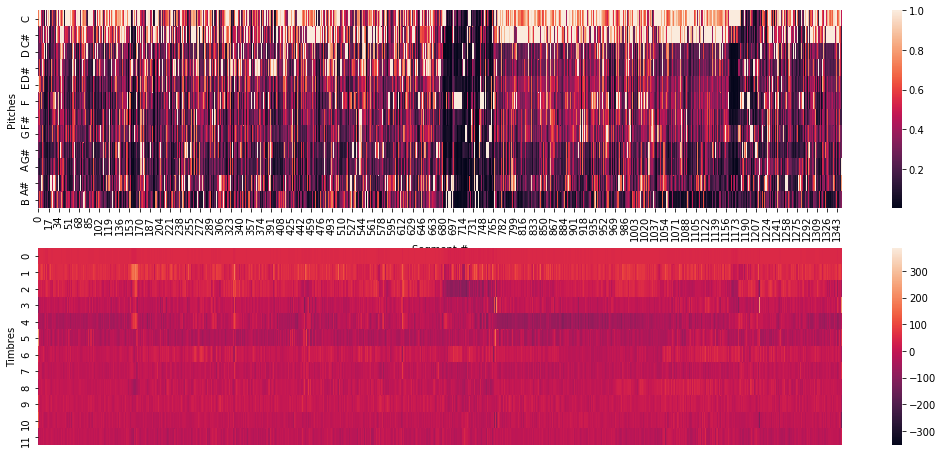

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
import random

%matplotlib inline

x = random.randint(0,df.shape[0]-2)

for i in df.index[x:x+1]:
    name = f'### {df.title[i]}\n\nArtist: *{df.artist_name[i]}*\n\nRelease:*{df.release[i]}*'
    if df.year[i] != 0:
        name += f'\n\nreleased {df.year[i]}'
    name += '\n\n'
    name += f'Tags: {df.top50_tags[i]}'
    display(Markdown(name))
    
    # plot a scatterplot of the segment starts
    plt.figure(figsize=(18,8))

    # plot a heatmap of the pitch data
    plt.subplot(2,1,1)
    ax = sns.heatmap(df.segments_pitches[i].T, 
                     yticklabels=("C", "C#", "D", "D#", "E", "F", "F#", "G",
                                 "G#", "A", "A#", "B")
                    )
    ax.set(ylabel="Pitches")
    ax.set(xlabel="Segment #")

    # plot a heatmap of the timbre data
    plt.subplot(2,1,2)
    ax = sns.heatmap(df.segments_timbre[i].T, xticklabels=False)
    ax.set(ylabel="Timbres")
    plt.show()
    plt.close()
    

# Build and train the CRNN

In [12]:
try:
  # %tensorflow_version magic only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow.keras import layers
#
# model adapted from music_tagger_crnn.py at https://github.com/keunwoochoi/music-auto_tagging-keras
#

# input_shape = (12, None, 1)
input_shape = (96, 1366, 1)

channel_axis = 3
freq_axis = 1
time_axis = 2

# Parameters from Choi, et. al for 3,000,000 parameter size model
CNN1_N = 169
CNN2_N = 339
CNN3_N = 339
CNN4_N = 339
RNN1_N = 169
RNN2_N = 169

model = tf.keras.Sequential()

# # Input block
model.add(layers.Input(shape=input_shape))
model.add(layers.ZeroPadding2D(padding=(0, 37)))
model.add(layers.BatchNormalization(axis=freq_axis, name='bn_0_freq'))

# First Convolutional Block
model.add(layers.Conv2D(filters=CNN1_N, kernel_size=(3,3), padding='same', name='conv1'))
model.add(layers.BatchNormalization(axis=channel_axis, name='bn1'))
model.add(layers.ELU())
model.add(layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), name='pool1'))
model.add(layers.Dropout(rate=0.1, name='dropout1'))

# Second Convolutional Block
model.add(layers.Conv2D(filters=CNN2_N, kernel_size=(3, 3), padding='same', name='conv2'))
model.add(layers.BatchNormalization(axis=channel_axis, name='bn2'))
model.add(layers.ELU())
model.add(layers.MaxPool2D(pool_size=(3, 3), strides=(3, 3), name='pool2'))
model.add(layers.Dropout(rate=0.1, name='dropout2'))

# Third Convolutional Block
model.add(layers.Conv2D(filters=CNN3_N, kernel_size=(3, 3), padding='same', name='conv3'))
model.add(layers.BatchNormalization(axis=channel_axis, name='bn3'))
model.add(layers.ELU())
model.add(layers.MaxPool2D(pool_size=(4, 4), strides=(4, 4), name='pool3'))
model.add(layers.Dropout(rate=0.1, name='dropout3'))

# Fourth convolutional Block
model.add(layers.Conv2D(filters=CNN4_N, kernel_size=(3, 3), padding='same', name='conv4'))
model.add(layers.BatchNormalization(axis=channel_axis, name='bn4'))
model.add(layers.ELU())
model.add(layers.MaxPool2D(pool_size=(4, 4), strides=(4, 4), name='pool4'))
model.add(layers.Dropout(rate=0.1, name='dropout4'))

# reshaping
model.add(layers.Reshape(target_shape=(15, CNN4_N)))

# RNN (GRU) blocks
model.add(layers.GRU(units=RNN1_N, return_sequences=True, name='gru1'))
model.add(layers.GRU(units=RNN2_N, return_sequences=False, name='gru2'))
model.add(layers.Dropout(rate=0.3))

# Output
model.add(layers.Dense(units=50, activation='sigmoid', name='output'))

model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_6 (ZeroPaddin (None, 96, 1440, 1)       0         
_________________________________________________________________
bn_0_freq (BatchNormalizatio (None, 96, 1440, 1)       384       
_________________________________________________________________
conv1 (Conv2D)               (None, 96, 1440, 169)     1690      
_________________________________________________________________
bn1 (BatchNormalization)     (None, 96, 1440, 169)     676       
_________________________________________________________________
elu_21 (ELU)                 (None, 96, 1440, 169)     0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 48, 720, 169)      0         
_________________________________________________________________
dropout1 (Dropout)           (None, 48, 720, 169)     